#Assignment DeepRL Part II - Version 2

- The part of the code related to clonning the track was **not working as expected**.

- The code is now updated to set a fixed seed to the number generator.

- The seed is set by (STUDENTID1+STUDENTID2)%100 or STUDENTID1%100 so set the values **accordingly**.

- When the UseClonedTrack flag is set to false, the seed uses time to set its value.



Install dependencies

In [1]:
!apt-get update
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# install required system dependencies
!apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

!git clone https://github.com/openai/gym.git
%cd gym
!pip install -e .
!pip install stable-baselines[mpi]
!pip install stable-baselines3[extra]

%cd ..

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
fatal: destination path 'gym' already exists and is not an empty directory.
/home/yukie/Documents/APA/APA_Assignment_3/DeepRL_PartIandII/gym
Obtaining file:///home/yukie/Documents/APA/APA_Assignment_3/DeepRL_PartIandII/gym
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successful

Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import figure

import gym
import torch 
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import random
from gym import wrappers
import copy
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from PartI_lib import archs as archs
from PartI_lib import performance_evaluation as eval
# from PartI_lib import train_loop as tl
from PartI_lib import my_tools as mt


###################################################
###################################################
###################################################
STUDENTID1=2016116214;
STUDENTID2=2016193815;
###################################################
###################################################
###################################################



Deep RL Replay Buffer

In [3]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size
        self.counter = 0
        self.state_buffer = []
        self.action_buffer = []
        self.reward_buffer = []
        self.new_state_buffer = []
        self.terminal_buffer = []
        
    def store_tuples(self, state, action, reward, new_state, done):
        if len(self.state_buffer) < self.size:
            self.state_buffer.append(None)
            self.action_buffer.append(None)
            self.reward_buffer.append(None)
            self.new_state_buffer.append(None)
            self.terminal_buffer.append(None)
            
        self.counter = self.counter % self.size
        self.state_buffer[self.counter] = state
        self.action_buffer[self.counter] = action
        self.reward_buffer[self.counter] = reward
        self.new_state_buffer[self.counter] = new_state
        self.terminal_buffer[self.counter] = done
        self.counter += 1

    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch=[];
        action_batch=[];
        reward_batch=[];
        new_state_batch=[];
        done_batch=[];
        
        for a in batch:
            state_batch.append(self.state_buffer[a])
            action_batch.append(self.action_buffer[a])
            reward_batch.append(self.reward_buffer[a])
            new_state_batch.append(self.new_state_buffer[a])
            done_batch.append(self.terminal_buffer[a])
        return state_batch, action_batch, reward_batch, new_state_batch, done_batch





Default DQN arquitecture

In [4]:
import math

def size_after_maxpool(img_size,kernel_size, stride):
    ret = math.floor(1+(img_size-kernel_size)/stride)
    return ret

class DQN(nn.Module):

    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()
        
        self.input_size=inputs;
        self.output_size=outputs;
        self.imgSize=96;
        # self.size_a_maxpool = size_after_maxpool(96,3,2);
        
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=self.input_size, 
                      out_channels=64, 
                      kernel_size=5,
                      stride=1,
                      padding=2),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=3, stride=2),
            # nn.Conv2d(in_channels=64, 
            #           out_channels=32, 
            #           kernel_size=5,
            #           stride=1,
            #           padding=2),
            # nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=8, 
                      kernel_size=5,
                      stride=1,
                      padding=2),
            nn.ReLU(),
        )
        
        self.layers = nn.Sequential(
            nn.Linear(in_features=self.imgSize*self.imgSize*8, out_features=64),            #Add code here for DQN 
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=self.output_size),            #Add code here for DQN 
        )
        
       
        self.layersdueling = nn.Sequential(
            #Add code here for Dueling 
        )


        self.advantage = nn.Sequential(
            #Add code here for Dueling 
        )
        
        self.value = nn.Sequential(
           #Add code here for Dueling 
        )
  

###### Dueling configuration 
                                                    #############
###########    ############    #################    # advantage #           
#         #    #          #    #               # -> #############    
#   IMG   # -> # features # -> # layersdueling # -> #############
#         #    #  (CONVs) #    #     (FCs)     #    #   value   #
###########    ############    #################    #############
 

    def forward(self, x):
    
        if(useDueling):
            x=self.features(x)
            x = x.view(x.size(0), -1)
            x = self.layersdueling(x)
            advantage = self.advantage(x)
            value     = self.value(x)
            return value + advantage  - advantage.mean()
        else:
            x=self.features(x)
            x = x.view(x.size(0), -1)
            return self.layers(x)

    def policy(self,state):
       with torch.no_grad():
            return self.__call__(state.unsqueeze(0)).argmax()
     
    def getPolicy(self,state,eps_threshold):
        sample = random.random()
        if sample > eps_threshold:
            with torch.no_grad():
                return self.__call__(state.unsqueeze(0)).argmax()
        else:
            return  torch.tensor(random.randrange(self.output_size), device=device, dtype=torch.long)


OpenAI Environment CarRacing-v0

 
###    Description:
        Easiest continuous control task to learn from pixels, a top-down racing environment.
###    Observation:
        Type: Image (96x96x3)
        Some indicators are shown at the bottom of the window along with the state RGB buffer. From left to right: the true speed, four ABS sensors, the steering wheel position and gyroscope.
###    Actions:
        Discrete control is reasonable in this environment as well, on/off discretization is fine.
###    Reward:
        The reward is -0.1 every frame and +1000/N for every track tile visited, where N is the total number of tiles visited in the track. For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points.
###    Starting State:
        The tracks are randomly generated (switch to True the UseClonedTrack flag to activate this behavior) for each episode.
###    Episode Termination:
        Car is too faraway from the track.
        Car accumulated a negative reward after given iterations (see ResetCounter and InitCounter).
        Episode length is greater than 1000.
        All tiles are visited.
###     Solved Requirements:
        The game is solved when the agent consistently gets 900+ points.  


DQN movie generation (for visual evaluation in Google Colab)

In [5]:
def createMovie(Network,path,Filename,UseClone):
  
    env1 = gym.make("CarRacing-v0")
    envX = wrappers.Monitor(env1,path+'/'+Filename,force=True)
  
    
    if(UseClone):
       envX.seed((STUDENTID1+STUDENTID2)%100);
    else:
       envX.seed(time.time_ns());
    new_state = envX.reset()


    
    stackedStateX=[np.rollaxis(new_state, 2, 0).copy() for i in range(FrameStack)];
    state =torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameSize*FrameStack,96,96)) ).float().to(device)


    i=0
    Network.eval()
    resetStatus=0;   

    while True:
        envX.render()
        
        action = Network.policy(state);
        reward=0
        for x in range(ControlSteps):
            new_state, r, done, _ = envX.step(action_space[action.item()])
            reward+=r
            if(done):
                break
        if reward<0 and i>InitCounter:
            resetStatus=resetStatus+1;
        else:
            resetStatus=0
        
        stackedStateX.pop(0)
        
 
        stackedStateX.append(np.rollaxis(new_state, 2, 0).copy())
        state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameSize*FrameStack,96,96))).float().to(device)
        i=i+1;     
        if done or resetStatus>=ResetCounter: 
          break;

    envX.close()
    env1.close();
    Network.train()
    mp4list = glob.glob(path+'/'+Filename+'/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        # ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
        #         loop controls style="height: 400px;">
        #         <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        #      </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

Dummy Net with random policy

In [6]:
class RandomNet(nn.Module):

  def __init__(self,outputs):
      super(RandomNet, self).__init__()        
      self.output_size=outputs;
      

  def forward(self, x):
      return  x

  def policy(self,state):
      return  torch.tensor([[random.randrange(self.output_size)]], device=device, dtype=torch.long)
     
    




Parameters

In [7]:
action_space    = [
            (-1  , 1  , 0.2), (0, 1, 0.2), (1   , 1  , 0.2), #           Action Space Structure
            (-1  , 1  ,   0), (0, 1,   0), (1   , 1  ,   0), #        (Steering Wheel, Gas, Break)
            (-1  , 0  , 0.2), (0, 0, 0.2), (1   , 0  , 0.2), # Range        -1~1       0~1   0~1
            (-1  , 0  ,   0), (0, 0,   0), (1   , 0  ,   0)];
            # (-0.5, 0  ,   0),              (0.5 , 0  ,   0),
            # (-0.5, 0.5,   0),              (0.5 , 0.5,   0),
            # (-0.5, 0  , 0.5),              (0.5 , 0  , 0.5)];

 
n_actions=len(action_space)

#hyper-parameters
TotalEpisodes=1001;
MaxSteps=1000;
ControlSteps=3; # number of iterations the same action is executed in the environment 
FrameStack=3 # number of consecutive frames used to represent the state
FreezeCounter=25; # clone the model every X episodes
BatchSize=64;
exploration_threshold=1
exploration_threshold_min=0.01
exploration_decay=0.997
discount_factor=0.95
LearningRate=0.0001
LearningRateDecay=1
 
SaveAtCounter=25 # save model or video at every X episodes
ResetCounter=50 # maximum number of experiences with bad performance
InitCounter=20 # minimum number of experiences per episode
FrameSize=3; # 3 if RGB 1 if grayscale


# use these flags to enable Double DQN and Duelinng (Dueling DQN or Double Dueling DQN)
usedoubleDQN=False
useDueling=False

UseClonedTrack=True # forces the same Track for all episodes

Run the new netwwork with random policy

In [8]:
# randomnet=RandomNet(n_actions)
# createMovie(randomnet,"random",False)

Initialization and Parameters:


In [9]:
env = gym.make("CarRacing-v0")
spec = gym.spec("CarRacing-v0")


#network DQN
policy_net = DQN(FrameSize*FrameStack, n_actions).to(device)
target_net = DQN(FrameSize*FrameStack, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

buffer = ReplayBuffer(5000);  # max number of experiences in the buffer (may need to be smaller if CUDA memory errors occur).

optimizer = torch.optim.Adam(policy_net.parameters(), lr=LearningRate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=LearningRateDecay)

loss=  torch.nn.SmoothL1Loss()


DQN training

In [10]:
def trainModel(buffer_data):
    if buffer_data.counter < BatchSize:
        return 0.0

    state_batch, action_batch, reward_batch, new_state_batch, done_batch = buffer_data.sample_buffer(BatchSize)
    state_batch = torch.stack(state_batch).to(device)
    action_batch = torch.stack(action_batch).reshape(-1,1).to(device)
    new_state_batch = torch.stack(new_state_batch).to(device)
    reward_batch = torch.stack(reward_batch).reshape(-1,1).to(device)
    done_batch = torch.stack(done_batch).reshape(-1,1).to(device)

 
    if usedoubleDQN:
     
        #Add Double DQN code here
        print('Double DQN code Missing')

    else: 
        q_actual = torch.gather(policy_net(state_batch),1,index=action_batch)
        with torch.no_grad():
            q_max_next, _ = target_net(new_state_batch).max(dim=1)
            q_max_next=q_max_next.reshape(-1, 1)

        q_target = (q_max_next * discount_factor)*(1-done_batch) + reward_batch
        
        ll=loss(q_actual, q_target)

    optimizer.zero_grad()
    ll.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1)
    optimizer.step()

    return ll.item();

In [11]:
loss_val,scores, episodes,events, avg_scores,avg_scores20,exploration = [],[],[], [],[], [], []

bestScore=-99999;
at=0;
bestNet=copy.deepcopy(policy_net);

file_name = mt.set_name("arch",BatchSize,exploration_threshold,exploration_threshold_min,exploration_decay,discount_factor,LearningRate,LearningRateDecay)
file_path_ = mt.create_dir("results",file_name)
for f in range(TotalEpisodes):
    print("Episode: "+str(f)+" of "+str(TotalEpisodes))
    done  = False
    score = 0.0
    tloss = 0.0
 

    # disable to train using random tracks
    if(UseClonedTrack):
       env.seed((STUDENTID1+STUDENTID2)%100);
    else:
       env.seed(time.time_ns());
    
    new_state=env.reset()
   
 
    stackedState=[np.rollaxis(new_state, 2, 0).copy() for i in range(FrameStack)];
    state =torch.from_numpy(np.reshape(np.array(stackedState),(FrameSize*FrameStack,96,96)) ).float().to(device)
   
    if f % FreezeCounter == 0:
       print("########################################"+str(f)+" of "+str(TotalEpisodes))
       target_net.load_state_dict(policy_net.state_dict())
       
    if f % SaveAtCounter == 0:
      #torch.save(policy_net.state_dict(), "v2CarRacing_"+str(f)+'_model.ckpt')
       createMovie(policy_net,file_path_,"CarRacing_"+str(f),UseClonedTrack)
       
    resetStatus=0;
    i=0    
    
    for F in range(MaxSteps):
        #env.render()
        action = policy_net.getPolicy(state,exploration_threshold)
        reward=0
        for _ in range(ControlSteps):
            new_state, r, done, info = env.step(action_space[action.item()])
            reward+=r
            i=i+1
            if(done):
                break
        if reward<0 and i>InitCounter:
            resetStatus=resetStatus+1;
        else:
            resetStatus=0
            
        stackedState.pop(0)
        stackedState.append(np.rollaxis(new_state, 2, 0).copy())
        new_state=torch.from_numpy(np.reshape(np.array(stackedState),(FrameSize*FrameStack,96,96))).float().to(device)
        
        score += reward
        if(F<(MaxSteps-1)):
            buffer.store_tuples(state, action, torch.tensor(reward), new_state, torch.tensor(int(done)))
            
        state = new_state
        trainModel(buffer)


        if(done or resetStatus>=ResetCounter):
            break      

        if(score < -5): break;  
    exploration_threshold= exploration_threshold*exploration_decay if exploration_threshold > exploration_threshold_min else exploration_threshold_min

    if(score>bestScore):
        print(score,F)
        bestScore=score;
        bestNet=copy.deepcopy(policy_net);
        at=f;
    
    exploration.append(exploration_threshold)
    scores.append(score)
    episodes.append(f)
    events.append(F)
    avg_scores.append(score/F)
    avg_scores20.append(np.mean(scores[-20:]))

    if avg_scores20[-1] > 250: break;


torch.save(bestNet.state_dict(), "BestCarRacing_"+str(f)+'_'+str(bestScore)+'_model.ckpt')

Episode: 0 of 1001
Track generation: 1127..1419 -> 292-tiles track
########################################0 of 1001
Track generation: 1127..1419 -> 292-tiles track
16.55567010309244 150
Episode: 1 of 1001
Track generation: 1127..1419 -> 292-tiles track
17.156357388315193 274
Episode: 2 of 1001
Track generation: 1127..1419 -> 292-tiles track
Episode: 3 of 1001
Track generation: 1127..1419 -> 292-tiles track
46.17491408934617 246
Episode: 4 of 1001
Track generation: 1127..1419 -> 292-tiles track
Episode: 5 of 1001
Track generation: 1127..1419 -> 292-tiles track
Episode: 6 of 1001
Track generation: 1127..1419 -> 292-tiles track
Episode: 7 of 1001
Track generation: 1127..1419 -> 292-tiles track
Episode: 8 of 1001
Track generation: 1127..1419 -> 292-tiles track
Episode: 9 of 1001
Track generation: 1127..1419 -> 292-tiles track
Episode: 10 of 1001
Track generation: 1127..1419 -> 292-tiles track
Episode: 11 of 1001
Track generation: 1127..1419 -> 292-tiles track
Episode: 12 of 1001
Track gen

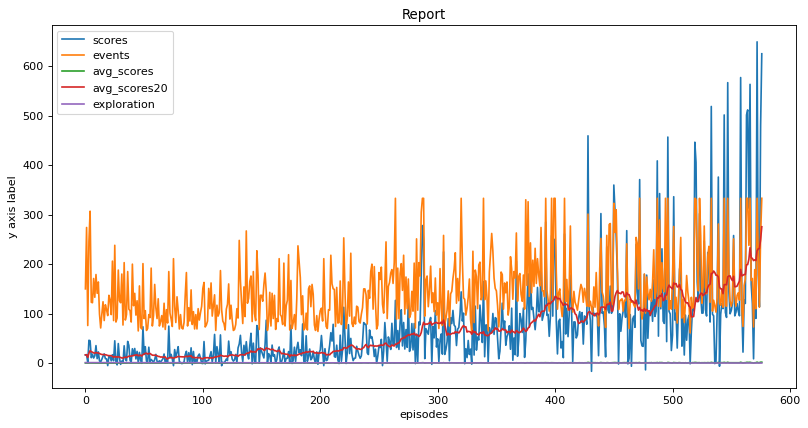

TypeError: report() missing 1 required positional argument: 'avg_scores100'

In [19]:
import importlib
importlib.reload(eval)
# /performance_evaluation)

# from PartI_lib import performance_evaluation as eval
eval.performance_evaluation(file_path_,episodes, scores, events, avg_scores, avg_scores20, exploration,[])
eval.report(file_path_,"arch",BatchSize,exploration_threshold,exploration_threshold_min,exploration_decay,discount_factor,
                    LearningRate,LearningRateDecay,episodes, scores, events, avg_scores, avg_scores20, exploration, 0,[])

Plot performance

In [ ]:
figure(figsize=(12, 6), dpi=80)
plt.plot(episodes, scores)
plt.plot(episodes, events)
plt.plot(episodes, avg_scores)
plt.plot(episodes, avg_scores20)
plt.plot(episodes, exploration)
plt.xlabel('episodes')
plt.ylabel('y axis label')
 
plt.title('Track Locked DQN '+str(usedoubleDQN)+' '+str(useDueling))
plt.legend(['scores', 'events', 'avg_scores', 'avg_scores20','exploration'])
plt.show()

View Best Results

In [ ]:
createMovie(bestNet,file_path_,'bestNet',UseClonedTrack)


